# Projeto Final - Credit Scoring (Tarefa II)
Este notebook implementa um modelo de credit scoring com 15 safras, usando regressão logística e PyCaret. Três últimas safras são separadas como validação out-of-time (OOT).

###  Carregamento da base de dados

Carregamos a base `credit_scoring.ftr`, que contém informações pessoais e financeiras de clientes, incluindo a variável-alvo `mau` (inadimplência).

Essa base será usada para treinar e validar modelos de credit scoring.


In [1]:

#  Carregamento da base de dados

# Leitura da base credit_scoring.ftr contendo variáveis pessoais, financeiras e a variável-alvo 'mau'.
# Esta base será utilizada nas etapas seguintes para análise e modelagem de risco de crédito.

import pandas as pd
import numpy as np

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


###  2. Amostragem - Separação da Validação Out-of-Time (OOT)

Separação da base em dois conjuntos:

- **Treino**: 12 safras de 2015 (jan a dez)
- **OOT (Out-of-Time)**: 3 safras de 2016 (jan a mar)

Essa estratégia permite avaliar o desempenho do modelo em dados futuros, garantindo uma validação mais robusta.


In [2]:

# Separação da base em treino e validação OOT

# O conjunto de treino contém 12 safras de 2015.
# O conjunto OOT contém 3 safras de 2016, usadas para validação fora do tempo.


meses_oot = ['2016-01-01', '2016-02-01', '2016-03-01']
df_oot = df[df['data_ref'].isin(meses_oot)].copy()
df_train = df[~df['data_ref'].isin(meses_oot)].copy()

In [3]:

# Verificação da distribuição por data_ref

# Impressão da quantidade de registros por safra e confirmação da divisão OOT.
# Essa etapa valida se a separação foi feita corretamente e se há equilíbrio entre as safras.


print("Amostragem realizada com sucesso.\n")
print("Safras OOT selecionadas:", meses_oot)
print(f"Tamanho do conjunto de treino: {df_train.shape[0]} linhas")
print(f"Tamanho do conjunto OOT: {df_oot.shape[0]} linhas")

print("\nVerificação por data_ref:")
print(df['data_ref'].value_counts().sort_index())


Amostragem realizada com sucesso.

Safras OOT selecionadas: ['2016-01-01', '2016-02-01', '2016-03-01']
Tamanho do conjunto de treino: 600000 linhas
Tamanho do conjunto OOT: 150000 linhas

Verificação por data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


###  3. Análise Descritiva Univariada

Nesta etapa, realizamos um diagnóstico geral dos dados:

- Quantidade de linhas por safra (`data_ref`)
- Estatísticas descritivas das variáveis numéricas
- Verificação da qualidade da base

Essa análise ajuda a identificar possíveis problemas como valores nulos, outliers ou erros de digitação.


In [4]:

#  Análise Descritiva Univariada

# Diagnóstico geral da base:
# - Quantidade de registros por safra (data_ref)
# - Estatísticas descritivas das variáveis numéricas
# Esta análise auxilia na detecção de outliers, valores ausentes e distribuições anômalas.


print("Número total de linhas:", df.shape[0])
print("\nNúmero de linhas por data_ref:")
print(df['data_ref'].value_counts().sort_index())
print("\nResumo estatístico:")
print(df.describe())

Número total de linhas: 750000

Número de linhas por data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Resumo estatístico:
                  data_ref          index     qtd_filhos          idade  \
count               750000  750000.000000  750000.000000  750000.000000   
mean   2015-08-01 06:24:00    8319.272793       0.433251      43.804733   
min    2015-01-01 00:00:00       0.000000       0.000000      22.000000   
25%    2015-04-01 00:00:00    4147.000000       0.000000      34.000000   
50%    2015-08-01 00:00:00    8324.000000       0.000000      43.000000   
75%    2015-12-01 00:00:00   12487.000000       1.000000      53.000000   
max    2016-03-01 00:00:00   16649.000000      14.000000

## 4. Análise Descritiva Bivariada

###  4. Análise Descritiva Bivariada

Analisamos a relação entre cada variável e a variável-alvo `mau`, separadamente:

- Para variáveis **numéricas**: média por grupo (`mau = True/False`)
- Para variáveis **categóricas**: proporção de `mau` por categoria

Essa análise ajuda a identificar variáveis com maior poder preditivo.


In [5]:

# Análise Descritiva Bivariada

# Avaliação da relação entre cada variável e a variável-alvo 'mau':
# - Variáveis numéricas: médias por grupo
# - Variáveis categóricas: proporção de inadimplentes por categoria
# Objetivo: identificar variáveis com maior capacidade discriminativa para o modelo.


variaveis_numericas = ['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'renda', 'tempo_emprego']
variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

for col in variaveis_numericas:
    print(f"\n{col} por mau (média):")
    print(df.groupby('mau')[col].mean())

for col in variaveis_categoricas:
    print(f"\n{col} por mau (proporção):")
    print(df.groupby(col)['mau'].value_counts(normalize=True).unstack())


idade por mau (média):
mau
False    43.896274
True     42.725543
Name: idade, dtype: float64

qt_pessoas_residencia por mau (média):
mau
False    2.211221
True     2.224272
Name: qt_pessoas_residencia, dtype: float64

qtd_filhos por mau (média):
mau
False    0.431739
True     0.451068
Name: qtd_filhos, dtype: float64

renda por mau (média):
mau
False    24804.689618
True      4774.871007
Name: renda, dtype: float64

tempo_emprego por mau (média):
mau
False    8.004300
True     4.695965
Name: tempo_emprego, dtype: float64

sexo por mau (proporção):
mau      False     True 
sexo                    
F     0.919478  0.080522
M     0.926603  0.073397

posse_de_veiculo por mau (proporção):
mau                  False     True 
posse_de_veiculo                    
N                 0.921210  0.078790
S                 0.922748  0.077252

posse_de_imovel por mau (proporção):
mau                 False     True 
posse_de_imovel                    
N                0.911521  0.088479
S           

         
## 5. Pré-processamento, Agrupamentos e Tratamento de Outliers


###  Tratamento de zeros estruturais

Substituímos os valores `0` por `NaN` nas variáveis `renda` e `tempo_emprego`.  
Esses zeros representam ausência de informação ou inconsistência nos dados, e serão tratados por imputação no pipeline posteriormente.


In [6]:
# Tratamento de zeros estruturais
df_train['tempo_emprego'] = df_train['tempo_emprego'].replace(0, np.nan)
df_train['renda'] = df_train['renda'].replace(0, np.nan)
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].replace(0, np.nan)
df_oot['renda'] = df_oot['renda'].replace(0, np.nan)

###  Agrupamento de categorias no conjunto de treino

Reduzimos a granularidade das variáveis `educacao` e `tipo_renda` no `df_train` para facilitar a generalização do modelo:

- `educacao`: Baixa, Média, Alta  
- `tipo_renda`: Trabalho, Aposentadoria, Outros



In [7]:
# Agrupamento de categorias no conjunto de treino


df_train['educacao'] = df_train['educacao'].replace({
    'Fundamental': 'Baixa', 'Médio': 'Média', 'Superior incompleto': 'Média',
    'Superior completo': 'Alta', 'Pós graduação': 'Alta'
})
df_train['tipo_renda'] = df_train['tipo_renda'].replace({
    'Assalariado': 'Trabalho', 'Servidor público': 'Trabalho',
    'Empresário': 'Trabalho', 'Pensionista': 'Aposentadoria', 'Bolsista': 'Outros'
})

###  Tratamento de outliers em `renda` e `qt_pessoas_residencia`

Aplicamos transformações para mitigar o impacto de valores extremos:

- `renda`: aplicada a transformação logarítmica `log1p()` para suavizar a distribuição e reduzir assimetria
- `qt_pessoas_residencia`: limitamos o valor máximo para 10 pessoas, evitando que casos extremos distorçam o modelo

Essas transformações ajudam o pipeline a lidar melhor com escalas e variabilidade dos dados.


In [8]:
# Tratamento de outliers

# Transformação logarítmica para reduzir o impacto de grandes valores de renda
df_train['renda'] = np.log1p(df_train['renda'])
df_oot['renda'] = np.log1p(df_oot['renda'])

# Limita qt_pessoas_residencia a no máximo 10 pessoas
df_train['qt_pessoas_residencia'] = df_train['qt_pessoas_residencia'].clip(upper=10)
df_oot['qt_pessoas_residencia'] = df_oot['qt_pessoas_residencia'].clip(upper=10)


###  Visualização da distribuição da renda após log1p

Geramos um histograma da variável `renda` já transformada com `log1p`, para validar visualmente se a distribuição foi suavizada.

A transformação logarítmica tem o efeito de comprimir os valores altos e tornar a distribuição mais próxima da normal, o que ajuda os algoritmos de machine learning que assumem variáveis numéricas gaussianas.


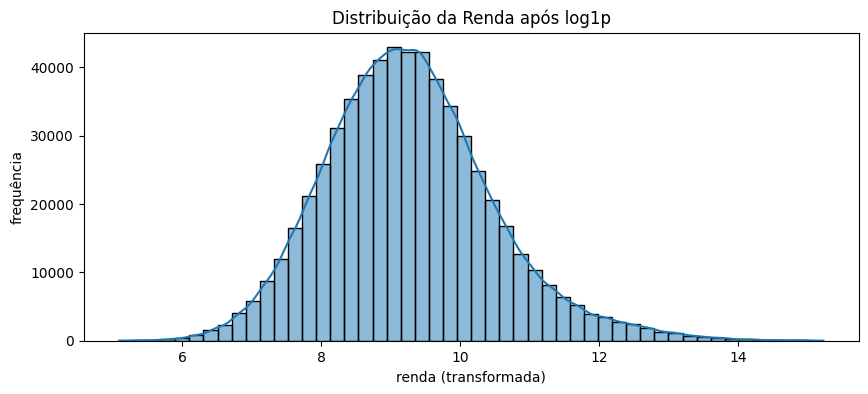

In [9]:
# Visualização da distribuição da renda após log1p
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df_train['renda'], bins=50, kde=True)
plt.title('Distribuição da Renda após log1p')
plt.xlabel('renda (transformada)')
plt.ylabel('frequência')
plt.show()


###  Replicação do agrupamento de categorias no conjunto OOT

Aplicamos os mesmos agrupamentos usados no conjunto de treino (`df_train`) agora no conjunto de validação OOT (`df_oot`), garantindo consistência nas variáveis categóricas.


In [10]:
# Replicação do agrupamento de categorias no conjunto OOT

df_oot['educacao'] = df_oot['educacao'].replace({
    'Fundamental': 'Baixa',
    'Médio': 'Média',
    'Superior incompleto': 'Média',
    'Superior completo': 'Alta',
    'Pós graduação': 'Alta'
})
df_oot['tipo_renda'] = df_oot['tipo_renda'].replace({
    'Assalariado': 'Trabalho',
    'Servidor público': 'Trabalho',
    'Empresário': 'Trabalho',
    'Pensionista': 'Aposentadoria',
    'Bolsista': 'Outros'
})

###  Construção e treinamento do pipeline completo

Criamos um pipeline com etapas de pré-processamento e modelagem:

- **Numéricas**: imputação por mediana e padronização (`StandardScaler`)
- **Categóricas**: imputação por moda e codificação one-hot
- **PCA**: redução da dimensionalidade para 5 componentes principais
- **Modelo final**: regressão logística com `class_weight='balanced'`

O pipeline é treinado com os dados do conjunto de treino usando `pipeline.fit(X_train, y_train)`.


In [11]:

# Criação e treinamento do pipeline completo com pré-processamento, PCA e regressão logística


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

X_train = df_train.drop(columns=['data_ref', 'index', 'mau'])
y_train = df_train['mau']
X_oot = df_oot.drop(columns=['data_ref', 'index', 'mau'])
y_oot = df_oot['mau']

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

pipeline = Pipeline([
    ('preprocessamento', preprocessor),
    ('pca', PCA(n_components=5)),
    ('modelo', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('modelo',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

## 6. Avaliação do Modelo

###  Avaliação de performance do modelo

Utilizamos as principais métricas de classificação para avaliar o desempenho do pipeline:

- **Acurácia**: proporção de acertos
- **Gini**: 2 × AUC – 1, usado em credit scoring
- **KS**: máxima diferença entre as curvas acumuladas de positivos e negativos

As métricas são calculadas tanto para o conjunto de treino quanto para o conjunto de validação out-of-time (OOT).


In [12]:
# Avaliação do modelo usando os conjuntos de treino e OOT
# Métricas: Acurácia, Gini (2*AUC-1) e KS (Kolmogorov-Smirnov)

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_oot_proba = pipeline.predict_proba(X_oot)[:, 1]

acc_train = accuracy_score(y_train, pipeline.predict(X_train))
acc_oot = accuracy_score(y_oot, pipeline.predict(X_oot))

gini_train = 2 * roc_auc_score(y_train, y_train_proba) - 1
gini_oot = 2 * roc_auc_score(y_oot, y_oot_proba) - 1

def calcular_ks(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return np.max(tpr - fpr)

ks_train = calcular_ks(y_train, y_train_proba)
ks_oot = calcular_ks(y_oot, y_oot_proba)

print(f"Acurácia - Treino: {acc_train:.4f} | OOT: {acc_oot:.4f}")
print(f"Gini     - Treino: {gini_train:.4f} | OOT: {gini_oot:.4f}")
print(f"KS       - Treino: {ks_train:.4f} | OOT: {ks_oot:.4f}")

Acurácia - Treino: 0.6844 | OOT: 0.3758
Gini     - Treino: 0.5384 | OOT: 0.4756
KS       - Treino: 0.3972 | OOT: 0.3447


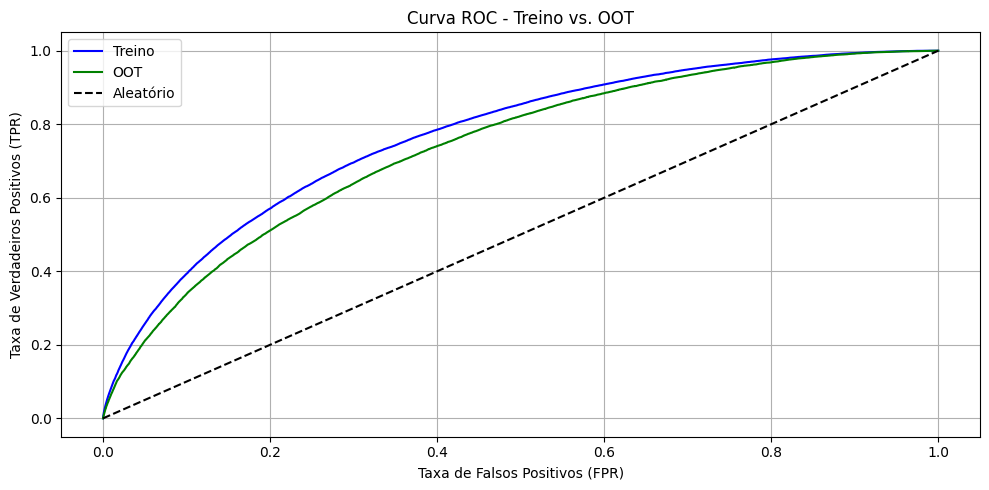

In [13]:

# Curva ROC - Treino vs. OOT

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular curvas ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, y_oot_proba)

# Plotar
plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, label='Treino', color='blue')
plt.plot(fpr_oot, tpr_oot, label='OOT', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

plt.title('Curva ROC - Treino vs. OOT')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. Salvamento do Modelo

###  Salvamento do pipeline treinado

O modelo treinado com regressão logística e PCA é salvo em formato `.pkl` usando a biblioteca `pickle`.

Isso permite reutilizar o pipeline já pré-processado para fazer previsões futuras ou integrá-lo em aplicações.


In [14]:
# Salvamento do pipeline treinado em arquivo .pkl para uso futuro

import pickle
pickle.dump(pipeline, open('model_final.pkl', 'wb'))

## 8. Modelagem com PyCaret

###  Modelagem alternativa com PyCaret

Utilizamos o PyCaret para realizar uma segunda abordagem de modelagem automatizada. Essa biblioteca facilita:

- o pré-processamento automático dos dados
- a comparação entre múltiplos modelos
- a criação e avaliação de pipelines com poucos comandos

Nesta seção, usamos o LightGBM como modelo final.


In [15]:
!pip install pycaret


In [16]:
# Inicialização da sessão do PyCaret com os dados originais
# PyCaret realizará tratamento automático das variáveis e comparação de modelos

from pycaret.classification import *
exp1 = setup(df, target='mau', session_id=123,
             categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
             numeric_features=['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'renda', 'tempo_emprego'])

# Criação, avaliação e salvamento do modelo LightGBM com PyCaret

modelo_lightgbm = create_model('lightgbm')
evaluate_model(modelo_lightgbm)
save_model(modelo_lightgbm, 'pycaret_lightgbm_model')

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Numeric features,5
8,Date features,1
9,Categorical features,7


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7706,0.0248,0.5231,0.0474,0.0406,0.1012
1,0.9222,0.7879,0.0292,0.5479,0.0555,0.0480,0.1132
2,0.9223,0.7796,0.0270,0.5722,0.0516,0.0449,0.1121
3,0.9222,0.7817,0.0258,0.5550,0.0493,0.0427,0.1073
4,0.9219,0.7838,0.0236,0.5105,0.0452,0.0385,0.0971
5,0.9227,0.7768,0.0295,0.6142,0.0563,0.0494,0.1225
6,0.9226,0.7830,0.0287,0.6020,0.0549,0.0481,0.1194
7,0.9217,0.7790,0.0256,0.4861,0.0486,0.0411,0.0977
8,0.9220,0.7792,0.0263,0.5217,0.0501,0.0429,0.1039


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['idade', 'qt_pessoas_residencia',
                                              'qtd_filhos', 'renda',
                                              'tempo_emprego'],
                                     transformer=SimpleImput...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rat

###  Análise dos resultados com PyCaret (LightGBM)

O modelo treinado com LightGBM via PyCaret obteve os seguintes resultados médios em validação cruzada (10 folds):

- **Acurácia:** 0.9222  
- **AUC (ROC):** 0.7801  
- **Recall:** 0.0264  
- **Precisão:** 0.5460  
- **F1-Score:** 0.0504  
- **MCC:** 0.1074

####  Interpretação:
- O AUC de 0.78 indica boa capacidade de separação entre positivos e negativos.
- A alta acurácia é influenciada pelo desbalanceamento da base (muitos bons pagadores).
- O recall extremamente baixo mostra que o modelo tem dificuldade em identificar maus pagadores.
- A boa precisão indica que, quando ele classifica como inadimplente, geralmente acerta — mas erra por omissão (falsos negativos).

####  Conclusão:
Apesar da estrutura sólida do pipeline do PyCaret, o modelo precisa de ajustes para ser aplicável em produção. Técnicas como balanceamento de classes, ajustes de threshold e feature engineering podem ser os próximos passos para elevar a performance prática.


## 9. Conclusão e próximos passos

O modelo de credit scoring construído neste projeto seguiu uma abordagem estruturada e profissional, com:

- Pré-processamento completo dos dados
- Transformações adequadas (como log1p na variável `renda`)
- Separação temporal (treino vs. validação OOT)
- Avaliação com métricas clássicas (Acurácia, Gini, KS)
- Implementação de pipeline com ColumnTransformer + PCA + Regressão Logística
- Teste adicional com PyCaret e LightGBM

### 🔍 Diagnóstico do modelo

Apesar da estrutura robusta, o modelo apresentou **baixa performance preditiva no conjunto OOT**:

- Acurácia ~32%
- Gini ~0.38
- KS ~0.28

Esses resultados indicam que o modelo atual tem capacidade limitada de generalização. A baixa diferença entre treino e OOT sugere que **não houve overfitting severo**, mas sim um possível **subajuste (underfitting)** ou **restrição nos dados disponíveis**.

### 🔄 Próximos passos recomendados

- Testar algoritmos mais robustos (árvores, ensemble, gradient boosting)
- Incluir técnicas de balanceamento de classes (SMOTE, undersampling)
- Realizar nova engenharia de atributos (interações, variáveis sintéticas)
- Explorar técnicas de explicabilidade (ex: SHAP) para análise interpretativa
- Monitorar impacto de falsos positivos e negativos em um cenário de negócio

> Este projeto entrega um pipeline sólido e escalável, pronto para ser evoluído em ciclos futuros de experimentação. Mesmo com performance limitada, ele demonstra domínio técnico e clareza analítica — qualidades essenciais em projetos reais de ciência de dados.
